Лабораторная работа №4. Реализация приложения по распознаванию номеров домов.


In [3]:
# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import pdb
import os
import scipy.io
from sklearn.model_selection import train_test_split
import tarfile
from six.moves import cPickle as pickle

l2_regularization = 1e-4

Using TensorFlow backend.


Задание 1.
Реализуйте глубокую нейронную сеть (полносвязную или сверточную) и обучите ее на синтетических данных (например, наборы MNIST (http://yann.lecun.com/exdb/mnist/) или notMNIST).

In [4]:
# Extract data

def extract_dataset():
    with open('../data/notMNIST_sanit.pickle', 'rb') as f:
        data = pickle.load(f)

    # reshape dataset because of error:
    # ValueError: Error when checking input: expected conv2d_input to have 4 dimensions,
    # but got array with shape (200000, 28, 28)
    for key, dataset in data.items():
        data[key] = dataset.reshape(*dataset.shape, 1)
    return data

def image_name(index):
  return chr(ord('A') + index)

dataset = extract_dataset()
train_images = dataset['train_dataset']
train_labels = dataset['train_labels']
valid_images = dataset['valid_dataset']
valid_labels = dataset['valid_labels']
test_images = dataset['test_dataset']
test_labels = dataset['test_labels']


In [5]:
numbers_model = keras.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=[5,5], padding='same', activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(pool_size=[2,2], strides=2),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(filters=32, kernel_size=[5,5], padding='valid', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=[2,2], strides=2),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(units=120, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=84, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation = 'softmax')
])

optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
numbers_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

numbers_model.summary()

numbers_model_history = numbers_model.fit(train_images,
                                      train_labels,
                                      epochs=10,
                                      validation_data=(valid_images, valid_labels))

test_loss, test_acc = numbers_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Задание 2.
После уточнения модели на синтетических данных попробуйте обучить ее на реальных данных (набор Google Street View). Что изменилось в модели?


In [6]:
# Extracting data

dataset_paths = [('test', "../data/housenames/test.tar.gz"),
                 ('train', "../data/housenames/train.tar.gz")]
for name, path in dataset_paths:
    if not os.path.exists('../data/housenames/' + name):
        print(name)
        tf = tarfile.open(path)
        files = tf.extractall('../data/housenames')
        tf.close()

houses_train_dataset= scipy.io.loadmat(os.path.join('../data/housenames/', 'train_32x32.mat'))
houses_test_dataset = scipy.io.loadmat(os.path.join('../data/housenames/', 'test_32x32.mat'))


# Fomratting of data

# 1) move axis to be like this: (num of imagex, h, w, dimensions)
houses_train_dataset['X'] = np.moveaxis(houses_train_dataset['X'], 3, 0)
houses_test_dataset['X'] = np.moveaxis(houses_test_dataset['X'], 3, 0)

# 2) subtract 1 from labels because they start from 1
houses_train_dataset['y'] = houses_train_dataset['y'] - 1
houses_test_dataset['y'] = houses_test_dataset['y'] - 1



houses_train_images, houses_valid_images, houses_train_labels, houses_valid_labels = train_test_split(
    houses_train_dataset['X'],
    houses_train_dataset['y']
)

houses_test_images = houses_test_dataset['X']
houses_test_labels = houses_test_dataset['y']


In [7]:
houses_model_v1 = keras.Sequential([
    keras.layers.Conv2D(32, 3, padding='same', input_shape=(32, 32, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

houses_model_v1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
houses_model_v1.summary()
houses_model_v1_history = houses_model_v1.fit(houses_train_images,
                                              houses_train_labels,
                                              epochs=10,
                                              validation_data=(houses_valid_images, houses_valid_labels),
                                              batch_size=128)
test_loss, test_acc = houses_model_v1.evaluate(houses_test_images,  houses_test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2097664   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

In [14]:
# version 2: + regularization to dense layer, remove batch_size during fitting + 1 dropout layer

houses_model_v2 = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    keras.layers.Dropout(0.25),

    keras.layers.Dense(units=10, activation = 'softmax')
])

houses_model_v2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

houses_model_v2.summary()
houses_model_v2_history = houses_model_v2.fit(houses_train_images,
                                              houses_train_labels,
                                              epochs=10,
                                              validation_data=(houses_valid_images, houses_valid_labels))
test_loss, test_acc = houses_model_v2.evaluate(houses_test_images,  houses_test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               2097664   
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)              

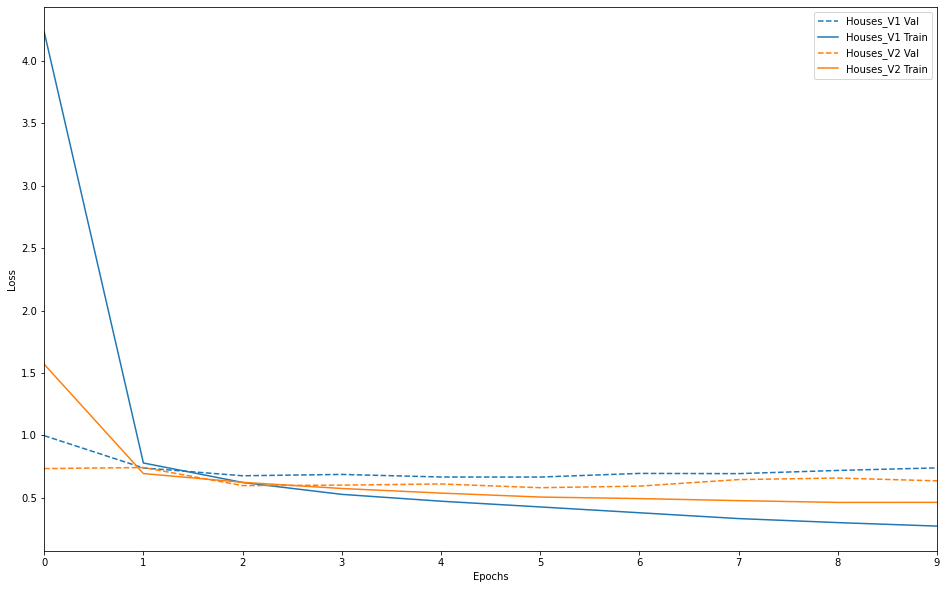

In [15]:
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_' + key],
                        '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

    plt.show()

plot_history(
[
    ('houses_v1', houses_model_v1_history),
    ('houses_v2', houses_model_v2_history),
], key='loss')